In [9]:
#1. 搭建的神经网络，使用olivettiface数据集进行训练。
# 使用不同的优化器观察结果

import torch
import torch.nn as nn
from torchvision.transforms.v2 import ToTensor     # 转换图像数据为张量
from sklearn.datasets import fetch_olivetti_faces  # 获取olivetti人脸数据集
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


In [15]:
#定义超参数
learning_rate = 0.001
epochs = 500
batch_size = 64

#GPU是否可用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#定义模型
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4096, 400) #定义三个全连接层
        self.bn1 = nn.BatchNorm1d(400)  #归一化,加速收敛，提高泛化性
        self.fc2 = nn.Linear(400, 400) 
        self.bn2 = nn.BatchNorm1d(400)
        self.fc3 = nn.Linear(400, 40) 
        self.drop = nn.Dropout(p=0.3) #随机丢弃一定比例的节点，防止过拟合(随机失活神经元，减少过拟合)
        self.act = nn.ReLU() #激活函数

    def forward(self, input_tensor):
        out = self.act(self.bn1(self.fc1(input_tensor)))
        out = self.drop(out) #随机失活,需要在传入下一个节点之前
        out = self.act(self.bn2(self.fc2(out)))
        out = self.drop(out)
        result = self.fc3(out)
        return result

cuda:0


In [11]:
# 引入数据
olivetti_faces = fetch_olivetti_faces(data_home='./', shuffle=True)
images = torch.tensor(olivetti_faces.data,dtype=torch.float32)
# print(images.shape)
targets = torch.tensor(olivetti_faces.target,dtype=torch.long)
# print(targets.shape)
dataset = [(img,lbl) for img,lbl in zip(images, targets)]
train_dl = DataLoader(dataset, batch_size = batch_size, shuffle=True)
# print(dataset)



In [16]:
model1 = MyModel().to(device)

# 引入损失函数 + 优化器
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate) # Adam优化器，自适应学习率调整
# optimizer = torch.optim.AdamW(model1.parameters(), lr=learning_rate) # 对Adam的改进，增加了权重衰减，以减少模型参数的权重
# optimizer = torch.optim.RMSprop(model1.parameters(), lr=learning_rate) # RMSProp 的核⼼思想是保持梯度平⽅的移动平均，并使⽤这个移动平均值来调整学习率，从⽽使参数更新更加稳定和⾼效
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate) # SGD 优化器，随机梯度下降，每次更新参数时只考虑当前样本的梯度

losses = []
#开始训练
for epoch in range(epochs):
    for data, target in train_dl:
        data = data.reshape(-1, 4096).to(device) #每个样本是一个长度为4096的向量，转换目的是为了匹配模型的输入层
        # print(data.shape)
        target = target.to(device)
        #前向计算
        outputs = model1(data)
        loss = loss_func(outputs, target)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"epoch: {epoch+1}/{epochs}, loss = {loss.item():.4f}")    

epoch: 1/500, loss = 3.5318
epoch: 2/500, loss = 3.6037
epoch: 3/500, loss = 3.3631
epoch: 4/500, loss = 3.6612
epoch: 5/500, loss = 3.5500
epoch: 6/500, loss = 3.5466
epoch: 7/500, loss = 3.5015
epoch: 8/500, loss = 3.3334
epoch: 9/500, loss = 3.2726
epoch: 10/500, loss = 2.9462
epoch: 11/500, loss = 3.0583
epoch: 12/500, loss = 3.0844
epoch: 13/500, loss = 3.1287
epoch: 14/500, loss = 2.8971
epoch: 15/500, loss = 2.9275
epoch: 16/500, loss = 2.8883
epoch: 17/500, loss = 2.7542
epoch: 18/500, loss = 3.0332
epoch: 19/500, loss = 2.7799
epoch: 20/500, loss = 2.6465
epoch: 21/500, loss = 2.7603
epoch: 22/500, loss = 2.4454
epoch: 23/500, loss = 2.7122
epoch: 24/500, loss = 2.5661
epoch: 25/500, loss = 2.5109
epoch: 26/500, loss = 2.7689
epoch: 27/500, loss = 2.6632
epoch: 28/500, loss = 2.4885
epoch: 29/500, loss = 2.5590
epoch: 30/500, loss = 2.3953
epoch: 31/500, loss = 2.4525
epoch: 32/500, loss = 2.3040
epoch: 33/500, loss = 2.5962
epoch: 34/500, loss = 2.2139
epoch: 35/500, loss = 2

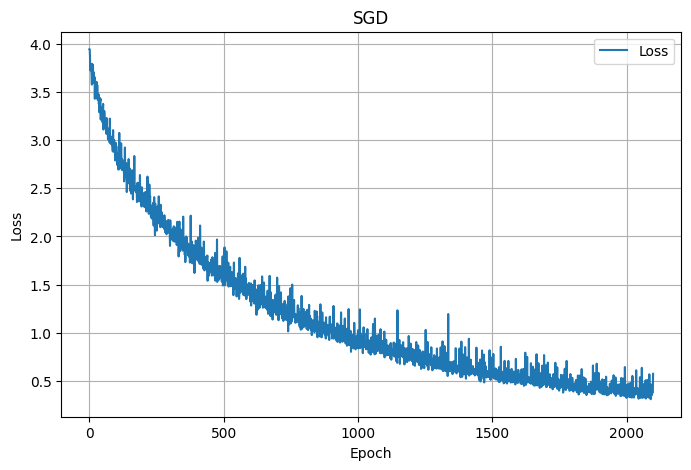

In [14]:
# 画losses 下降曲线图
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range(0, 2100), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD')
plt.legend()
plt.grid()
plt.show()